In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats

from sklearn.svm import LinearSVC, LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

Here, we import our TMPRSS2 QSAR Dataset, Dark Chemical Matter Dataset, and Screening Library 

In [2]:
# collect dataset
assays = pd.read_pickle('../processed_data/combined_dataset.pkl')
assays = assays[assays.activity_target.isin(['Active', 'Inactive'])]  # get rid of any 'Inconclusive'

dcm = pd.read_pickle('../processed_data/DarkChemicalMatter_processed.pkl.gz')

# testing data:
screening_data = pd.read_pickle('../processed_data/screening_data_processed.pkl')

In [3]:
screening_data

,source,name,morgan_fingerprint
0,drugbank,Bivalirudin,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,drugbank,Leuprolide,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,drugbank,Goserelin,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,drugbank,Gramicidin D,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,drugbank,Desmopressin,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
21019,broad,zotepine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
21020,broad,zoxazolamine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
21021,broad,zoxazolamine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
21022,broad,ZSTK-474,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Here, we combine our assay data and dark chemical matter data. We next  80%/20% train/test split. This data is split into a training set (80%) and a testing/validation set (20%)

In [4]:
X_assays = np.stack(assays.morgan_fingerprint)
y_assays = np.ones(len(X_assays))

X_dcm = np.stack(dcm.morgan_fingerprint)
y_dcm = np.zeros(len(X_dcm))

X_combined = np.append(X_assays, X_dcm, axis = 0)
y_combined = np.append(y_assays, y_dcm)

X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2)

Here we use SKLearn GridSearch CV function to identify optimal C parameter for our preliminary SVM Classifier (trained on training set only)

In [5]:
Cs = np.logspace(-6, 2, 16)
clf = GridSearchCV(estimator=LinearSVC(random_state=0, tol=1e-5), param_grid=dict(C=Cs), n_jobs=-1)
clf.fit(X_train, y_train) 
c_param_SVC_train = clf.best_estimator_.C

In [6]:
c_param_SVC_train 

0.7356422544596406

Using the C parameter calculated above, we determine the Total Accuracy, False Positive Rate, False Negative Rate of our SVM Classifier

In [7]:
SVM_validation = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, C=c_param_SVC_train))
SVM_validation.fit(X_train, y_train)

pred = SVM_validation.predict(X_test)
accuracy = np.sum(pred == y_test)/y_test.size
accuracy

/opt/miniconda3/envs/tmprss2/lib/python3.6/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9997147645024423

In [8]:
i = 0
false_positive = 0
total_positive = 0
false_negative = 0
total_negative = 0
while(i < len(pred)):
    if(y_test[i] == 0):
        total_negative += 1
        if(pred[i] == 1):
            false_positive += 1
    elif(y_test[i] == 1):
        total_positive += 1
        if(pred[i] == 0):
            false_negative += 1 
    i = i + 1

false_positive/total_positive

0.015306122448979591

In [9]:
false_negative/total_negative

0.00017952676744102544

In [10]:
## Total error
(false_positive+false_negative)/(total_positive+total_negative)

0.00028523549755767106

Here, we use SKLearn GridSearch CV function to identify optimal C parameter for our full SVM Classifier (trained on assays and Dark Chemical Matter)

In [11]:
Cs = np.logspace(-6, 2, 16)
clf = GridSearchCV(estimator=LinearSVC(random_state=0, tol=1e-5), param_grid=dict(C=Cs), n_jobs=-1)
clf.fit(X_combined, y_combined) 
c_param_SVC_test = clf.best_estimator_.C

/opt/miniconda3/envs/tmprss2/lib/python3.6/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [12]:
c_param_SVC_test

8.576958985908945

Here, we use our full SVM Classifier to identify potentially-active compounds from our screening library 

In [13]:
SVM_testing = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, C=c_param_SVC_test))
SVM_testing.fit(X_combined, y_combined)

screening_compounds = np.stack(screening_data.morgan_fingerprint)

pred = SVM_testing.predict(screening_compounds)
screening_data['predictions'] = pred
inactiveCompounds = screening_data[(screening_data['predictions'] == 0)].index
active_screening_compounds = screening_data.drop(inactiveCompounds)

/opt/miniconda3/envs/tmprss2/lib/python3.6/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [14]:
len(active_screening_compounds)

504

Next, we identify the subset of the training data for which Ki values can be scaled to TMPRSS2 for use in regression analysis. This data is split into a training set (80%) and a testing/validation set (20%)

In [15]:
y_assays_logKi_raw = np.log10(assays.acvalue_scaled_to_tmprss2)
nan_array = np.isnan(y_assays_logKi_raw)
not_nan = ~nan_array
y_assays_logKi = y_assays_logKi_raw[not_nan]
X_assays = X_assays[not_nan]

train_X, test_X, train_y, test_y = train_test_split(X_assays, y_assays_logKi, test_size=0.2)

Next, we use SKLearn GridSearch CV function to identify optimal C parameter for our preliminary Support Vector Regressor (trained on training set only)

In [16]:
# Use SKLearn GridSearch CV function to identify optimal C parameter for SVM regression (training set)
Cs = np.logspace(-6, 2, 16)
clf = GridSearchCV(estimator=LinearSVR(random_state=0, tol=1e-5), param_grid=dict(C=Cs), n_jobs=-1)
clf.fit(train_X, train_y) 
c_param_SVR_test = clf.best_estimator_.C


In [17]:
c_param_SVR_test

0.0630957344480193

Using the C paramater calculated above, we calculate the RMSE of our regressor and the correlation coefficient between our predicted and ground-truth values.

/opt/miniconda3/envs/tmprss2/lib/python3.6/site-packages/sklearn/svm/_base.py:975: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVR RMSE:0.9440120268128477
(0.7044069501774843, 5.399159586057514e-14)


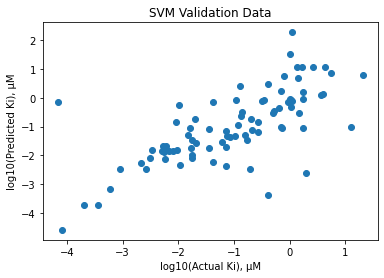

In [18]:
#Run SVM regression using SKLearn on test set. Linear regression for prediction accuracy
svmReg = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5, C=c_param_SVR_test))
svmReg.fit(train_X, train_y)

pred = svmReg.predict(test_X)
MSE = mean_squared_error(test_y, pred)
RMSE = np.sqrt(MSE)
print("SVR RMSE:{}".format(RMSE))

plt.scatter(test_y, pred)
plt.xlabel('log10(Actual Ki), μM')
plt.ylabel('log10(Predicted Ki), μM')
plt.title('SVM Validation Data')

corr = scipy.stats.pearsonr(test_y, pred)
print(corr)

Next, we use SKLearn GridSearch CV function to identify optimal C parameter for our full Support Vector Regressor (trained on training set and testing set)

In [19]:
#SKLearn C parameter optimization
Cs = np.logspace(-6, 2, 16)
clf_full = GridSearchCV(estimator=LinearSVR(random_state=0, tol=1e-5), param_grid=dict(C=Cs), n_jobs=-1)
clf_full.fit(X_assays, y_assays_logKi) 
c_param_full = clf_full.best_estimator_.C


In [20]:
c_param_full 

0.018478497974222907

Finally, using this C parameter, we screen the active compounds identified by our SVM Classifier to identify the compounds which are predicted to bind most effectively to TMPRSS2

In [21]:
#Run regressor (trained on full dataset)
test_compounds = np.stack(active_screening_compounds.morgan_fingerprint)

svmReg_full = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5, C=c_param_full))
svmReg_full.fit(X_assays, y_assays_logKi)
pred_values = svmReg_full.predict(test_compounds)

In [22]:
#identify top hits
active_screening_compounds['pred_value'] = pred_values
active_screening_compounds.sort_values(by='pred_value', inplace=True)
active_screening_compounds.head(20)

,source,name,morgan_fingerprint,predictions,pred_value
10797,reframe,Nafamostat,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.0,-4.573876
19603,broad,substance-p,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.0,-3.270127
10749,reframe,Camostat,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1.0,-3.063754
4725,drugbank,"Sar9, Met (O2)11-Substance P","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-2.878925
10877,broad,"[sar9,met(o2)11]-substance-p","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-2.878925
10789,reframe,RWJ-58643,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-2.231467
10747,reframe,Sepimostat mesilate,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-2.119771
2513,drugbank,RWJ-56423,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0,-2.051523
10791,reframe,Telaprevir,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",1.0,-2.013405
4645,drugbank,Telaprevir,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",1.0,-2.013405


Text(0.5, 1.0, 'Predicted Ki Values of Potentially-Active Compounds')

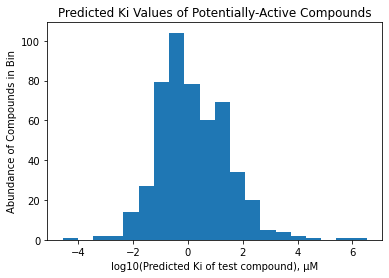

In [23]:
plt.hist(active_screening_compounds.pred_value, bins = 20)
plt.xlabel('log10(Predicted Ki of test compound), μM')
plt.ylabel('Abundance of Compounds in Bin')
plt.title('Predicted Ki Values of Potentially-Active Compounds')

Here, we save our results with duplicates removed, keeping lowest predicted value

In [25]:
active_screening_compounds["name"] = active_screening_compounds["name"].str.upper()
active_screening_compounds.drop_duplicates(subset=['name'], keep='first', inplace=True)
active_screening_compounds['validation_RMSE'] = RMSE
active_screening_compounds.to_csv('../results/SVM_results.csv')